* https://velog.io/@bae_mung/%EB%9D%BC%EC%A6%88%EB%B2%A0%EB%A6%AC%ED%8C%8C%EC%9D%B4-4-openCV-tensorflow-%EC%84%B8%ED%8C%85
* https://blog.naver.com/roboholic84/221140338041
* https://www.dinolabs.ai/339
* https://pyimagesearch.com/2020/01/27/yolo-and-tiny-yolo-object-detection-on-the-raspberry-pi-and-movidius-ncs/

In [1]:
import sys
import numpy as np
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/pjreddie/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5955, done.
remote: Total 5955 (delta 0), reused 0 (delta 0), pack-reused 5955
Receiving objects: 100% (5955/5955), 6.37 MiB | 13.57 MiB/s, done.
Resolving deltas: 100% (3931/3931), done.


In [ ]:
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
! cd darknet

In [ ]:
!make

make: *** No targets specified and no makefile found.  Stop.


In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-09-20 11:33:55--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  38.9MB/s    in 6.5s    

2022-09-20 11:34:02 (36.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
# yolov3-tiny.cfg -> 라즈베리파이용 경량화 모델의 cfg 파일
# yolov3-tiny.weights -> pretrained data

In [ ]:
# yolov3-tiny.weights download
!wget https://pjreddie.com/media/files/yolov3-tiny.weights

--2022-09-26 15:44:30--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  14.6MB/s    in 2.3s    

2022-09-26 15:44:33 (14.6 MB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]



In [ ]:
!cd darknet

In [ ]:
!./darknet partial cfg/yolov3-tiny.cfg yolov3-tiny.weights yolov3-tiny.conv.15 15

/bin/bash: ./darknet: Is a directory


In [ ]:
!./darknet detect cfg/yolov3-tiny.cfg yolov3-tiny.weights data/dog.jpg

/bin/bash: ./darknet: Is a directory


In [ ]:

!cp /coco.names /content/drive/MyDrive/Colab\ Notebooks/yolov3

cp: cannot stat '/coco.names': No such file or directory


In [ ]:
# Yolov3-tiny model load
net = cv2.dnn.readNet("/content/yolov3-tiny.weights", "/content/darknet/cfg/yolov3-tiny.cfg")
classes = []
with open("/content/drive/MyDrive/Colab Notebooks/yolov3/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [ ]:
# import sample image
#img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/2020-02-065.드론이동체(전방고정)_sample/AM/4-FLY-AI02-SUN-20M-15-CITY-Cheongna-1202-11-02-55-L-Y_0003284.jpg')
#img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/2020-02-065.드론이동체(전방고정)_sample/샘플_드론택배/2020-11-17/songdo/city/PM/5-FLY-AI06-CLOUD-11M-15-CITY-Songdo-1117-14-46-56-L-Y-S26_0000522.jpg')
#img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/yolov3/1.jpg")
#img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/yolov3/drone.jpg")
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/yolov3/darknet/data/kite.jpg')
#img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape
print(img.shape)

(900, 1352, 3)


In [ ]:
# 이미지 특징 잡고 크기를 조정
#blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
blob = cv2.dnn.blobFromImage(img, 0.00392, (800,1080), (0, 0, 0), True, crop=False)
print(blob.shape)

net.setInput(blob)
outs = net.forward(output_layers)

(1, 3, 1080, 800)


In [ ]:
# confidence가 0.5 이상이면 해당 Object라고 탐지
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)            
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [ ]:
# 박스 중복을 방지하기 위해 noise를 지워주는 과정
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

In [ ]:
from google.colab.patches import cv2_imshow

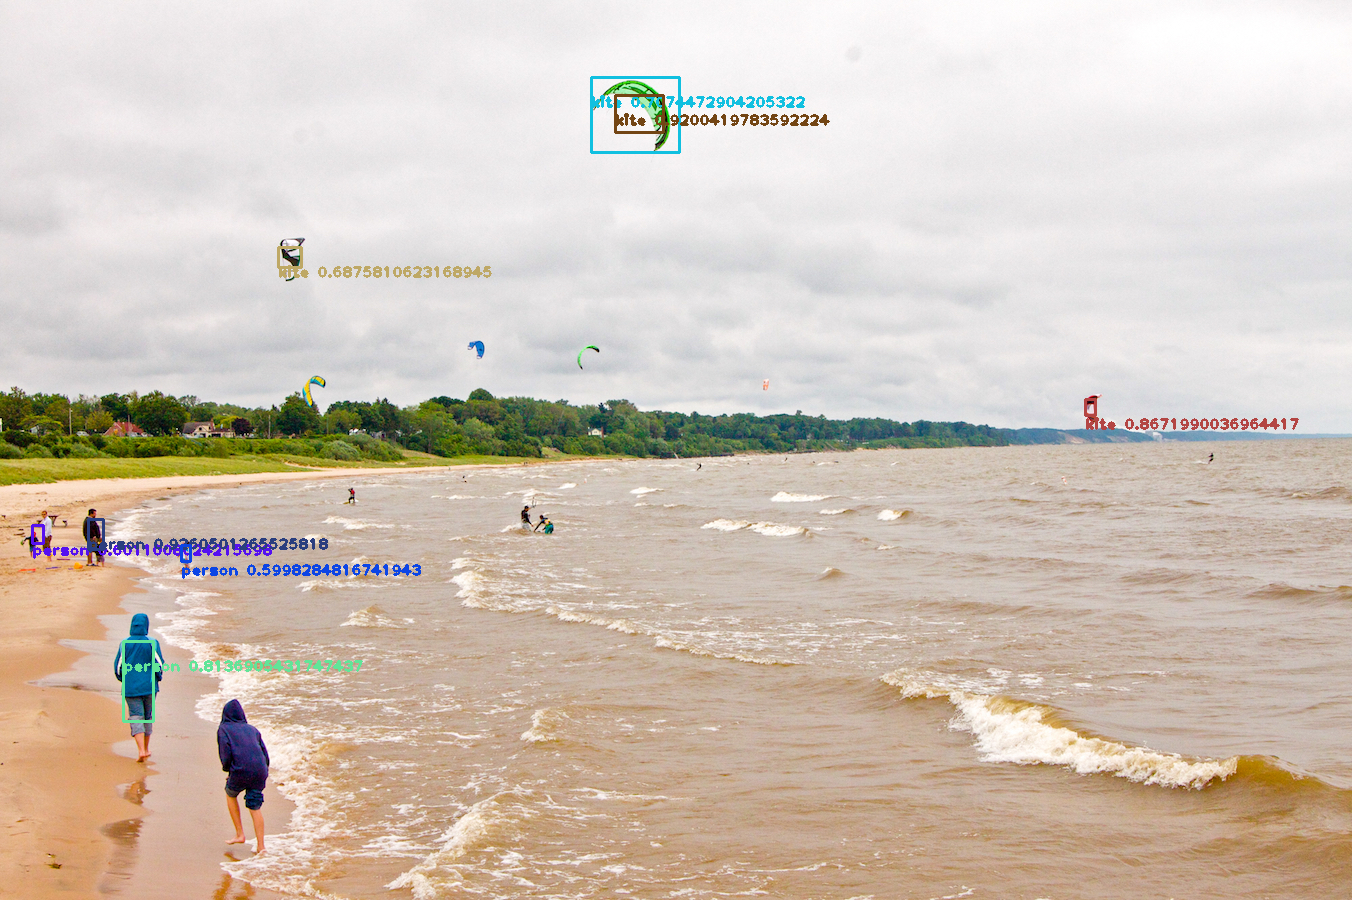

In [ ]:
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label+' '+str(confidences[i]), (x, y + 30), font, 1, color, 2)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 학습 후 탐지

In [4]:
import os

In [3]:
# Yolov3-tiny model load
net = cv2.dnn.readNet("/content/drive/MyDrive/darknet-master/results/train2/lagrange_yolov3-tiny_4000.weights", "/content/drive/MyDrive/darknet-master/custom/lagrange_yolov3-tiny.cfg")
classes = []
with open("/content/drive/MyDrive/darknet-master/custom/classes.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [17]:
img_list = os.listdir('/content/drive/MyDrive/road_data/image')
img = cv2.imread('/content/drive/MyDrive/road_data/image/'+img_list[200])
height, width, channels = img.shape
print(img.shape)

(416, 416, 3)


In [18]:
blob = cv2.dnn.blobFromImage(img, 0.00392, (416,416), (0, 0, 0), True, crop=False)
print(blob.shape)

net.setInput(blob)
outs = net.forward(output_layers)

(1, 3, 416, 416)


In [19]:
# confidence가 0.5 이상이면 해당 Object라고 탐지
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)            
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [20]:
# 박스 중복을 방지하기 위해 noise를 지워주는 과정
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

In [21]:
from google.colab.patches import cv2_imshow

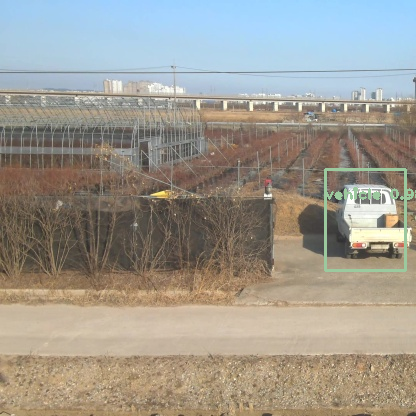

In [22]:
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label+' '+str(confidences[i]), (x, y + 30), font, 1, color, 2)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [39]:
class ObjectDetection():
  def __init__(self,img_dir, dst_dir, save_flag=True):
    self.img_dir = img_dir
    self.dst_dir = dst_dir
    self.save_flag = save_flag
    self.img_name = img_dir.split('/')[-1]


    
  def objectdetection(self):
    net = cv2.dnn.readNet("/content/drive/MyDrive/darknet-master/results/train2/lagrange_yolov3-tiny_4000.weights", "/content/drive/MyDrive/darknet-master/custom/lagrange_yolov3-tiny.cfg")
    classes = []
    with open("/content/drive/MyDrive/darknet-master/custom/classes.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    #colors = np.random.uniform(0, 255, size=(len(classes), 3))
    colors = ((0,255,0),(0,0,255))

    img = cv2.imread(self.img_dir)
    height, width, channels = img.shape
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416,416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # confidence가 0.5 이상이면 해당 Object라고 탐지
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)            
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            
            color = colors[class_id]
            confidences[i] = round(confidences[i],2)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label+' '+str(confidences[i]), (x, y + 30), font, 1, color, 2)
    if self.save_flag==True:
      cv2.imwrite(self.dst_dir+'/'+self.img_name, img)
      print('saved detected img on ',self.dst_dir+'/'+self.img_name)
    else:
      cv2_imshow(img)
      cv2.waitKey(0)
      cv2.destroyAllWindows()


In [40]:
img_list = os.listdir('/content/drive/MyDrive/road_data/image')
img_list.sort()
for i in range(0,2000,50):
  pic = ObjectDetection('/content/drive/MyDrive/road_data/image/'+img_list[i],'/content/drive/MyDrive/drone_dataset/detected', True)
  pic.objectdetection()

saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road0.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road1042.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road1088.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road1132.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road1178.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road1222.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road1268.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road1312.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road1358.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road1402.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road1448.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/road1493.jpg
saved detected img 

In [44]:
jonan_list = os.listdir('/content/drive/MyDrive/jonanja_data/image')
jonan_list.sort()
print(len(jonan_list))
for i in range(1,2000,50):
  pic = ObjectDetection('/content/drive/MyDrive/jonanja_data/image/'+jonan_list[i],'/content/drive/MyDrive/drone_dataset/detected', True)
  pic.objectdetection()

2325
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/jonanja1.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/jonanja1120.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/jonanja1195.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/jonanja1251.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/jonanja1330.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/jonanja1403.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/jonanja1496.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/jonanja1571.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/jonanja1617.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/jonanja1704.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/detected/jonanja1769.jpg
saved detected img on  /content/drive/MyDrive/drone_dataset/det